In [17]:
import numpy as np
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as td
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [18]:
class CNNAE(nn.Module):
    def __init__(self):
        super(CNNAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(32, 64, 7),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.PReLU(),
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

In [20]:
def plot_reconstructions(model, data_loader, n_images=5, device="cpu"):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_images = batch[:n_images].to(device)
            recon_images = model(input_images)
            break

    fig, axes = plt.subplots(2, n_images, figsize=(10, 4))
    for i in range(n_images):
        # Display original images
        img = input_images[i].cpu().numpy().transpose(1, 2, 0)
        img_normalized = normalize_image(img)
        axes[0, i].imshow(img_normalized)
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # Display reconstructed images
        recon_img = recon_images[i].cpu().numpy().transpose(1, 2, 0)
        recon_img_normalized = normalize_image(recon_img)
        axes[1, i].imshow(recon_img_normalized)
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

    plt.show()

In [23]:
def compute_physical_constraint_loss(output):
    dx = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
    dy = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8

    dx = dx.view(1, 1, 3, 3).to(device)
    dy = dy.view(1, 1, 3, 3).to(device)

    grad_x_x = F.conv2d(output[:, 0:1], dx, padding=1)
    grad_x_y = F.conv2d(output[:, 0:1], dy, padding=1)
    grad_y_x = F.conv2d(output[:, 1:2], dx, padding=1)
    grad_y_y = F.conv2d(output[:, 1:2], dy, padding=1)
    grad_z_x = F.conv2d(output[:, 2:3], dx, padding=1)
    grad_z_y = F.conv2d(output[:, 2:3], dy, padding=1)
    grad_z_z = F.conv2d(output[:, 2:3], torch.zeros_like(dy), padding=1)

    div = torch.abs(grad_x_x + grad_x_y) + torch.abs(grad_y_x + grad_y_y) + torch.abs(grad_z_x + grad_z_y + grad_z_z)
    constraint_loss = torch.mean(div)

    return constraint_loss


In [24]:
if __name__ == "__main__":
    # %%
    learning_rate = 0.0005
    batch_size = 64
    num_epochs = 100
    alpha = 0.1  # 物理约束损失的权重
    #DEVICE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 初始化网络
    model = CNNAE().to(device)
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练数据加载器
    data = np.load("data4D.npy", allow_pickle=True)
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    train_data = torch.from_numpy(train_data).to(device)
    test_data = torch.from_numpy(test_data).to(device)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)



    wandb.init(
        # set the wandb project where this run will be logged
        project="MagAE_2D",

        # track hyperparameters and run metadata
        config={
            "learning_rate": learning_rate,
            "architecture": "CNN",
            "dataset": "2DMag",
            "epochs": num_epochs,
            "batch_size": batch_size,
        })


    for epoch in range(num_epochs):
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)

            # 使用物理信息损失函数
            reconstruction_loss = criterion(outputs, data)
            constraint_loss = compute_physical_constraint_loss(outputs)
            loss = reconstruction_loss + alpha * constraint_loss



            #loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()

        wandb.log({"Epochs": epoch + 1, "loss": loss.item()})

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    with torch.no_grad():
        test_loss = 0
        for data in test_loader:
            data = data.to(device)
            recon_batch = model(data)
            test_loss += criterion(recon_batch, data).item()
        test_loss /= len(test_loader.dataset)
        wandb.log({"test_loss": test_loss})
        print(f"Test Loss: {test_loss:.4f}")


    wandb.finish()

Using device: cuda


Epoch [1/100], Loss: 0.0557
Epoch [2/100], Loss: 0.0561
Epoch [3/100], Loss: 0.0486
Epoch [4/100], Loss: 0.0460
Epoch [5/100], Loss: 0.0496
Epoch [6/100], Loss: 0.0425
Epoch [7/100], Loss: 0.0359
Epoch [8/100], Loss: 0.0403
Epoch [9/100], Loss: 0.0385
Epoch [10/100], Loss: 0.0389
Epoch [11/100], Loss: 0.0440
Epoch [12/100], Loss: 0.0407
Epoch [13/100], Loss: 0.0378
Epoch [14/100], Loss: 0.0410
Epoch [15/100], Loss: 0.0423
Epoch [16/100], Loss: 0.0356
Epoch [17/100], Loss: 0.0350
Epoch [18/100], Loss: 0.0385
Epoch [19/100], Loss: 0.0340
Epoch [20/100], Loss: 0.0313
Epoch [21/100], Loss: 0.0361
Epoch [22/100], Loss: 0.0268
Epoch [23/100], Loss: 0.0225
Epoch [24/100], Loss: 0.0218
Epoch [25/100], Loss: 0.0213
Epoch [26/100], Loss: 0.0219
Epoch [27/100], Loss: 0.0216
Epoch [28/100], Loss: 0.0197
Epoch [29/100], Loss: 0.0235
Epoch [30/100], Loss: 0.0178
Epoch [31/100], Loss: 0.0203
Epoch [32/100], Loss: 0.0192
Epoch [33/100], Loss: 0.0196
Epoch [34/100], Loss: 0.0177
Epoch [35/100], Loss: 0

Epochs,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▆▅▅▅▅▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁
test_loss,▁
Epochs,100
loss,0.01395
test_loss,7e-05


In [6]:
torch.save(model,"AE2D.pkl")

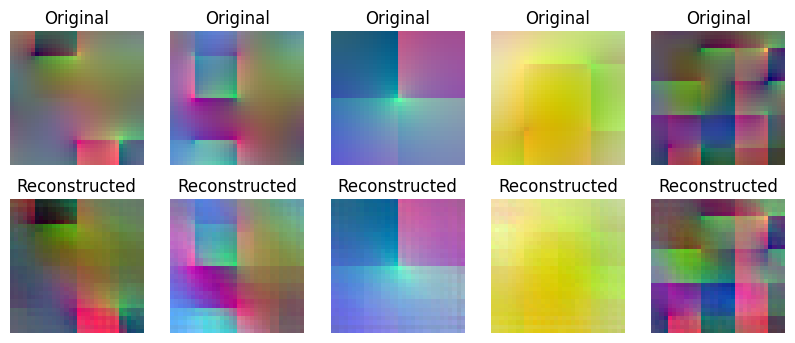

In [25]:

with torch.no_grad():
    plot_reconstructions(model, test_loader, n_images=5, device=device)

In [13]:
# 计算数据大小
original_size = 3 * 32 * 32
compressed_size = 256 * 1 * 1

# 计算压缩率
compression_rate = original_size / compressed_size

print(f"Compression rate: {compression_rate:.4f}")

Compression rate: 12.0000
